In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from skimage.filters import hessian

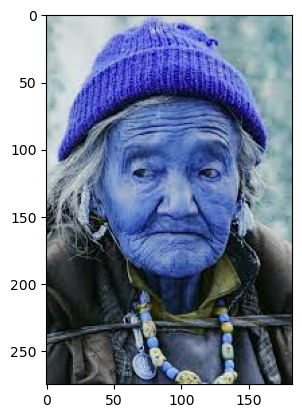

In [2]:
image = cv2.imread(r'C:\Users\pranj\Desktop\Wrinkles Dataset\w.jpg')
plt.imshow(image)

In [3]:
image.shape

(275, 183, 3)

In [4]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [5]:
#converting into grayscale image
gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img)
img_mean= np.mean(image)

for x,y,w,h in faces : 
    cropped_img = image[y:y+h,x:x+w]
    edges = cv2.Canny(cropped_img,img_mean-25, img_mean+25)        
    number_of_edges = np.count_nonzero(edges)
    
if number_of_edges > 1000:
    print("Wrinkle Found ")
    print("Number of edges: ", number_of_edges)
else:
    print("No Wrinkle Found ")

Wrinkle Found 
Number of edges:  5275


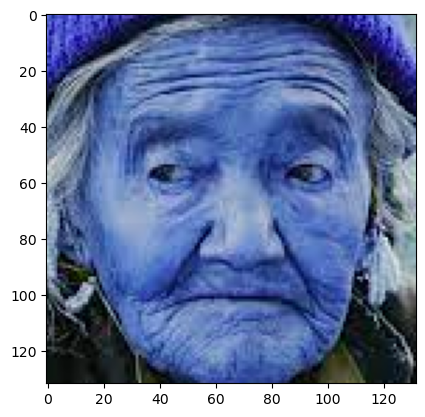

In [6]:
plt.imshow(cropped_img)

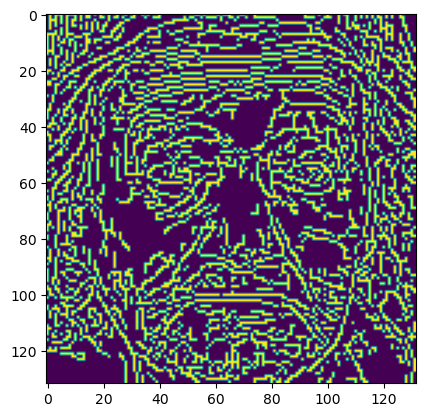

In [7]:
plt.imshow(edges)

Percentage of wrinkles: 77.2 %


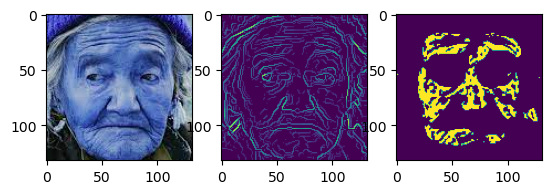

In [8]:

def Detect_Wrinkles(img, weak_th = None, strong_th = None):
      
    # conversion of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
       
    # Noise reduction step
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
       
    # Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
      
    # Conversion of Cartesian coordinates to polar 
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
       
    # setting the minimum and maximum thresholds 
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
      
    # getting the dimensions of the input image  
    height, width = img.shape
       
    # Looping through every pixel of the grayscale 
    # image
    for i_x in range(width):
        for i_y in range(height):
               
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
               
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
              
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
              
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
              
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
               
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
   
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
   
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)              
    ids = np.zeros_like(img)
       
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
              
            grad_mag = mag[i_y, i_x]
              
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
  
    return mag

canny_img = Detect_Wrinkles(cropped_img)

# calculating hessian to calculate percentage
cropped_gray_img= cv2.cvtColor(cropped_img,cv2.COLOR_BGR2GRAY)
hessian_img= hessian(cropped_gray_img, mode='constant')


# Displaying the input and output image  
f, plots = plt.subplots(1, 3) 
plots[0].imshow(cropped_img)
plots[1].imshow(canny_img)
plots[2].imshow(hessian_img)
if number_of_edges > 1000:
    print("Percentage of wrinkles: "+ str(100-np.argmax(hessian_img)/100)+" %")
else:
    print("Percentage of wrinkles: "+ str((np.argmin(hessian_img)/100)-100)+" %")